In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git
    
from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)
           

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [2]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 30000
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

In [5]:
from acdc.data.ioi import good_names
from collections import defaultdict
name_tokens = set([model.to_single_token(" " + name) for name in good_names])
print(name_tokens)
print(data.data.size())
name_positions = defaultdict(lambda: [])
for i in range(data.data.size()[0]):
    prompt_tokens = data.data[i]
    name_pos = 0
    for i, tok in enumerate(prompt_tokens):
        if tok.item() in name_tokens:
            name_positions[name_pos].append(i) # +1 because conv
            name_pos += 1
    if name_pos != 5: raise ValueError(f"data point {model.to_str_tokens(data)} does not have 5 names")

{50178, 46600, 31755, 11276, 10765, 46604, 33811, 46612, 16916, 18966, 12824, 32794, 7195, 33821, 33313, 37921, 29222, 31270, 28712, 28200, 37930, 18985, 7727, 24112, 36400, 32817, 5171, 44085, 35382, 14912, 30274, 20554, 15435, 33357, 49231, 38994, 21587, 7252, 40537, 27738, 44123, 44124, 14943, 45664, 15458, 49765, 19046, 35944, 29804, 23662, 37497, 22138, 27773, 28798, 33407, 27264, 9857, 14468, 35972, 6277, 4744, 32905, 32393, 22671, 20628, 32920, 17560, 21661, 16543, 31903, 18089, 16553, 28331, 41131, 20145, 46262, 30397, 41151, 22723, 23239, 14538, 17100, 37073, 22739, 49365, 16598, 31959, 47831, 22234, 23259, 20189, 45790, 29927, 46312, 31465, 46831, 31472, 29936, 26355, 6393, 26876, 8444, 26878, 6911, 25856, 21249, 19717, 8966, 38150, 26888, 27917, 39184, 48401, 24336, 6416, 23316, 37144, 31513, 42266, 29989, 27434, 45867, 36139, 29489, 27955, 27443, 22838, 7993, 13114, 13629, 28991, 40771, 25413, 44870, 18247, 47944, 35657, 26953, 13651, 27991, 26456, 48990, 34655, 16225, 2851

In [17]:
import torch
from tqdm.notebook import tqdm

LAYER = 39
batch_size = 40

hook = f"blocks.{LAYER}.hook_ssm_input"

name_averages = defaultdict(lambda: {})
counts = defaultdict(lambda: {})

TOTAL_AVG_NAME = "total"

for tok in name_tokens:
    for name_i in range(len(name_positions)):
        name_averages[name_i][tok] = torch.zeros([model.cfg.E], device=model.cfg.device)
        counts[name_i][tok] = 0

for batch_start in tqdm(list(range(0, data.data.size()[0], batch_size))):
    batch_end = min(data.data.size()[0], batch_start+batch_size)
    data_batch = data.data[batch_start:batch_end]
    logits, activations = model.run_with_cache(data_batch, names_filter=[hook], fast_ssm=True, fast_conv=True)
    for name_i in range(len(name_positions)):
        positions = torch.tensor(name_positions[name_i][batch_start:batch_end], device=model.cfg.device)
        batch_name_tokens = data_batch[torch.arange(batch_end-batch_start),positions]
        ssm_inputs = activations[hook]
        for batch_i, name_tok in enumerate(batch_name_tokens):
            #print(ssm_inputs[batch_i, position].size())
            try:
                position = positions[batch_i]+1
                name_averages[name_i][name_tok.item()] = ssm_inputs[batch_i, position]
                name_averages['all'][name_tok.item()] = ssm_inputs[batch_i, position]
                #name_averages[name_i][TOTAL_AVG_NAME] += ssm_inputs[batch_i, position]
                counts[name_i][name_tok.item()] += 1
                #counts[name_i][TOTAL_AVG_NAME] += 1
            except:
                print(model.to_str_tokens([name_tok]))
                raise
    
print(counts)
for name_i in range(len(name_positions)):
    for name_tok in list(name_averages.keys()):
        #name_averages[name_i][name_tok] = name_averages[name_i][name_tok] / counts[name_i][name_tok]
        pass   
    

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<function <lambda> at 0x7f973116f490>, {0: {50178: 238, 46600: 172, 31755: 186, 46604: 184, 10765: 176, 11276: 202, 33811: 158, 46612: 210, 16916: 172, 18966: 188, 12824: 196, 32794: 202, 7195: 164, 33821: 196, 37921: 232, 33313: 226, 31270: 184, 29222: 188, 28712: 180, 18985: 180, 37930: 170, 28200: 178, 7727: 174, 24112: 186, 36400: 222, 32817: 188, 5171: 188, 44085: 176, 35382: 192, 14912: 174, 30274: 200, 20554: 180, 15435: 156, 33357: 146, 49231: 172, 38994: 214, 21587: 172, 7252: 180, 40537: 202, 27738: 212, 44123: 166, 44124: 202, 14943: 182, 45664: 118, 15458: 188, 49765: 190, 19046: 194, 35944: 226, 29804: 170, 23662: 162, 37497: 198, 22138: 168, 27773: 240, 28798: 232, 33407: 226, 27264: 218, 9857: 214, 14468: 180, 6277: 144, 35972: 214, 4744: 192, 32905: 160, 32393: 202, 22671: 218, 20628: 168, 32920: 344, 17560: 204, 5119: 138, 21661: 184, 16543: 144, 31903: 266, 18089: 186, 16553: 154, 28331: 184, 41131: 196, 20145: 186, 46262: 188, 30397: 184, 41151: 254, 2272

In [49]:
import random
random.seed(27)

DO_DIFF = False

model_kwargs = {"fast_ssm": True, "fast_conv": True}

original_corrects = {}
original_replaces = {}
replace_corrects = {}
replace_replaces = {}
patched_corrects = {}
patched_replaces = {}

for position_1 in range(3):
    for position_2 in range(5):
        print(position_1, position_2)
        original_correct = []
        original_replace = []
        replace_correct = []
        replace_replace = []
        patched_correct = []
        patched_replace = []

        original_corrects[(position_1, position_2)] = original_correct
        original_replaces[(position_1, position_2)] = original_replace
        replace_corrects[(position_1, position_2)] = replace_correct
        replace_replaces[(position_1, position_2)] = replace_replace
        patched_corrects[(position_1, position_2)] = patched_correct
        patched_replaces[(position_1, position_2)] = patched_replace
        
        num_found = 0
        while True:
            data_i = random.choice(list(range(data.data.size()[0])))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i]
            answer_tok = data.correct[data_i][0]
            answer = model.to_str_tokens(answer_tok)[0]
            replace_tok = data.correct[patched_i][0].item()
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            
            def replace_hook(
                x,
                hook,
                position,
                replace_vec,
                replace_add_vec
            ):
                if not replace_vec is None:
                    x[0, position] = replace_vec
                if not replace_add_vec is None:
                    x[0, position] += replace_add_vec
                return x
            
            answer_positions = []
            for name_i in range(len(name_positions)):
                position = name_positions[name_i][data_i]
                if data_tokens[position].item() == answer_tok:
                    answer_positions.append((name_i, position))
            
            #print("answer positions", answer_positions)
            hooks = []
            bad = False
            for name_i, position in answer_positions:
                if not name_i == position_1 or len(answer_positions) > 2:
                    bad = True
                
                name_i = position_2
                replace_vec = name_averages[name_i][replace_tok]
                # two ways to do it
                # diff(name) = avg - name
                # if we add this it should "erase" name
                # if we subtract this it should "add" name
                # so we can do
                # replace_add_vec = diff(answer) - diff(replace)
                #diff_answer = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][answer_tok]
                #diff_replace = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][replace_tok]
                #replace_add_vec = diff_answer - diff_replace
                # this is (avg-a) - (avg-r) = r-a
                # in other words the average doesn't matter for this
                # and it's just subtract avg for a and add average for b
                replace_add_vec = name_averages[name_i][replace_tok] - name_averages[name_i][answer_tok.item()]
                # then we do
                # replace_vec
                # we have x
                # we want y
                # we can do
                # x-y
                # and apply it to y
                #replace_diff = name_averages[name_i][TOTAL_AVG_NAME]
        
                if DO_DIFF:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec)))
                else:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None)))
            if bad:
                continue
            else:
                num_found += 1
            
            #logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            #original_correct.append(logits[0,last_token_pos,answer_tok].item())
            #original_replace.append(logits[0,last_token_pos,replace_tok].item())
            if num_found % 10 == 0:
                print(num_found)
            logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            replace_correct.append(logits_modified[0,last_token_pos,answer_tok].item())
            replace_replace.append(logits_modified[0,last_token_pos,replace_tok].item())
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 100:
                break
    


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

0 0
10
20
30
40
50
60
70
80
90
100
0 1
10
20
30
40
50
60
70
80
90
100
0 2
10
20
30
40
50
60
70
80
90
100
0 3
10
20
30
40
50
60
70
80
90
100
0 4
10
20
30
40
50
60
70
80
90
100
1 0
10
20
30
40
50
60
70
80
90
100
1 1
10
20
30
40
50
60
70
80
90
100
1 2
10
20
30
40
50
60
70
80
90
100
1 3
10
20
30
40
50
60
70
80
90
100
1 4
10
20
30
40
50
60
70
80
90
100
2 0
10
20
30
40
50
60
70
80
90
100
2 1
10
20
30
40
50
60
70
80
90
100
2 2
10
20
30
40
50
60
70
80
90
100
2 3
10
20
30
40
50
60
70
80
90
100
2 4
10
20
30
40
50
60
70
80
90
100


In [50]:

n_correct_matrix = torch.zeros([3,5])

for pos1 in range(3):
    for pos2 in range(5):
        #original_diff = -torch.tensor(original_correct) + torch.tensor(original_replace)
        replace_diff = -torch.tensor(replace_corrects[(pos1,pos2)]) + torch.tensor(replace_replaces[(pos1,pos2)])
        #patched_diff = -torch.tensor(patched_correct) + torch.tensor(patched_replace)
        
        #print(f'original min diff {torch.min(original_diff)} max diff {torch.max(original_diff)} avg diff {torch.mean(original_diff)}')
        #print(f'replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')
        #print(f'patch min diff {torch.min(patched_diff)} max diff {torch.max(patched_diff)} avg diff {torch.mean(patched_diff)}')

        n_correct_matrix[pos1, pos2] = torch.sum(replace_diff > 0)/101.0
        #print(f'original n correct {torch.sum(original_diff < 0)} / {original_diff.size()[0]}')
        #print(f'replace n correct {torch.sum(replace_diff < 0)} / {original_diff.size()[0]}')
        #print(f'patch n correct {torch.sum(patched_diff < 0)} / {original_diff.size()[0]}')

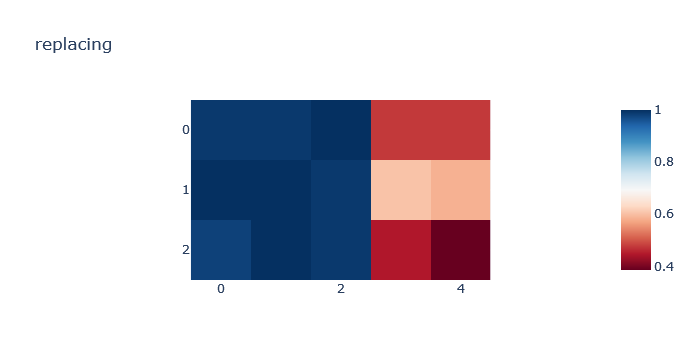

In [54]:

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show()

imshow(n_correct_matrix, color_continuous_midpoint=None, y=[0,1,2], title='replacing')

In [42]:
counts

defaultdict(<function __main__.<lambda>()>,
            {0: {50178: 238,
              46600: 172,
              31755: 186,
              46604: 184,
              10765: 176,
              11276: 202,
              33811: 158,
              46612: 210,
              16916: 172,
              18966: 188,
              12824: 196,
              32794: 202,
              7195: 164,
              33821: 196,
              37921: 232,
              33313: 226,
              31270: 184,
              29222: 188,
              28712: 180,
              18985: 180,
              37930: 170,
              28200: 178,
              7727: 174,
              24112: 186,
              36400: 222,
              32817: 188,
              5171: 188,
              44085: 176,
              35382: 192,
              14912: 174,
              30274: 200,
              20554: 180,
              15435: 156,
              33357: 146,
              49231: 172,
              38994: 214,
              21587:

In [55]:
n_correct_matrix

tensor([[0.9901, 0.9901, 1.0000, 0.4752, 0.4752],
        [1.0000, 1.0000, 0.9901, 0.6040, 0.5842],
        [0.9802, 1.0000, 0.9901, 0.4455, 0.3861]])

In [133]:
from sklearn.linear_model import LinearRegression
import numpy as np
# we want to predict the name from the representation
# there are two ways to do this:
# 1. Predict the probability of a rep being a name (output logits for each name)
# 2. Output the name embedding
# we'll start with the second one because it is more general, if that doesn't work we can try the first one


# we're basically doing a tuned lens sorta? idk
# lets start with not batched

# okay so say we are trying to output the name embedding
# on layer i, that could mean:
#    predict emb after it's projected into E space (which is after norm, but before conv)
#    predict emb after conv
#    predict emb after conv and silu
#    predict emb from hidden state or some other internal rep
# the point is that we train this linear map for some specific thing, then how well it performs suggests how well that thing encodes our data,
# so we can try it for lots of intermediate stuff
# some of the maps won't work, that's ok
from mamba_lens.input_dependent_hooks import clean_hooks
import torch
from transformer_lens.hook_points import HookPoint
from jaxtyping import Float
from tqdm import tqdm
import math
# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
clean_hooks(model)

# make sure we have no overlap
#joined_data = torch.cat([data.data, data.valid_data], dim=0)
#torch.sort(joined_data, dim=0)
#unique = torch.unique(joined_data, dim=0)
#torch.manual_seed(27)
# shuffle data
#unique = unique[torch.randperm(unique.size()[0])]
#B = unique.size()[0]//3
# split into train valid and test
#dataset, vdataset, tdataset = unique[:B], unique[B:2*B], unique[2*B:3*B]
dataset = data.data
vdataset = data.valid_data



from acdc.data.ioi import good_names
from collections import defaultdict
name_tokens = set([model.to_single_token(" " + name) for name in good_names])


name_tok_to_class = {}
for i, tok in enumerate(sorted(list(name_tokens))):
    name_tok_to_class[tok] = i

def get_name_positions(dat):
    name_positions = defaultdict(lambda: [])
    for i in tqdm(list(range(dat.size()[0]))):
        prompt_tokens = dat[i]
        name_pos = 0
        for i, tok in enumerate(prompt_tokens):
            if tok.item() in name_tokens:
                name_positions[name_pos].append(i)
                name_pos += 1
        if name_pos != 5: raise ValueError(f"data point {model.to_str_tokens(data)} does not have 5 names")
    return name_positions

data_name_positions, vdata_name_positions = get_name_positions(dataset), get_name_positions(vdataset)

model_kwargs = {
    "fast_ssm": True,
    "fast_conv": True,
}

BATCH_SIZE = 300
batch_size = BATCH_SIZE

B,L = dataset.size()

# for each position that varies, for each other position, fit a linear model

global probing_dataset_X
probing_dataset_X = []
def dataset_gathering_hook(
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int
):
    global probing_dataset_X
    probing_dataset_X.append(x[:,position,:].cpu())
    return x

layer = 39

linear_models = []
E = model.cfg.E
divTerm = float(math.sqrt(math.sqrt(float(E))*E))
for name_i in range(5):
    
    # make dataset
    
    def get_linear_classification_X(activations, layer, batch_i, position_x):
        vec = activations[f'blocks.{layer}.hook_ssm_input'][batch_i,position_x].view(-1)
        return (vec / torch.linalg.norm(vec, ord=2) / divTerm).view(1,-1).detach().cpu().numpy()

    def get_linear_classification_Y(labels):
        B = labels.size()[0]
        Y = np.zeros([B,len(name_tokens)])
        #Y = model.embedding.weight[input_data[:,position_y]]
        #return Y.detach().cpu().numpy()
        Y[:] = -1 # predict a vector with -1 for incorrect class and 1 for correct class
        for i in range(B):
            value = labels[i].item()
            Y[i,name_tok_to_class[value]] = 1
        return Y/math.sqrt(float(model.cfg.E))
    
    names_filter = [f'blocks.{layer}.hook_ssm_input']
    
    print(f"collecting data...")

    def get_training_data(dat, name_positions, batch_size):
        X = []
        Y = []
        for batch_start in tqdm(list(range(0, dat.size()[0], batch_size))):
            batch_end = min(batch_start + batch_size, dataset.size()[0])
            data_batch = dat[batch_start:batch_end]
            positions = torch.tensor(name_positions[name_i][batch_start:batch_end], device=model.cfg.device)
            name_tokens = data_batch[torch.arange(batch_end-batch_start),positions]
            logits, activations = model.run_with_cache(data_batch, names_filter=names_filter, **model_kwargs)
            for batch_i in range(batch_end-batch_start):
                #print(ssm_inputs[batch_i, position].size())
                position = positions[batch_i] + 1 # +1 because conv
                bX = get_linear_classification_X(activations=activations, layer=layer, batch_i=batch_i, position_x=position)
                X.append(bX)
                Y.append(name_tokens[batch_i].item())
        X = np.concatenate(X, axis=0)
        Y = torch.tensor(Y)
        Y = get_linear_classification_Y(labels=Y)
        return X, Y

    X, Y = get_training_data(dat=dataset, name_positions=data_name_positions, batch_size=BATCH_SIZE)
    
    linear_model = LinearRegression()
    linear_model.fit(X, Y)
    linear_models.append(linear_model)
    #del X
    #del Y
    torch.cuda.empty_cache()
    vX, vY = get_training_data(dat=vdataset, name_positions=vdata_name_positions, batch_size=BATCH_SIZE)
    
    pY = linear_model.predict(vX)
    # we want cosine similarity to actual embedding vectors
    #avg_sim = cosine_similarity(pY, vY).mean().item()
    predicted_inds = np.argmax(pY, axis=1)
    actual_inds = np.argmax(vY, axis=1)
    acc = np.sum(predicted_inds==actual_inds)/float(predicted_inds.shape[0])
    print(f"position {name_i} layer {layer} acc {acc}")
    #outpaut_accuracies[position_i, layer, other_position] = avg_sim

print(f"these token positions vary their value: {positions_that_vary}")


100%|█████████████████████████████████████████████████████████████████████████| 120000/120000 [00:22<00:00, 5441.52it/s]


collecting data...


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [07:02<00:00,  1.06s/it]


position 0 layer 39 acc 1.0
collecting data...


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [07:02<00:00,  1.06s/it]


position 1 layer 39 acc 1.0
collecting data...


 28%|██████████████████████▎                                                          | 110/400 [01:57<05:08,  1.06s/it]


KeyboardInterrupt: 

In [134]:
import random
random.seed(27)
np.random.seed(27)

class NameBasis(object):
    def __init__(self, linear_model):
        self.linear_model = linear_model
        #       [C,E] [E,1] [C] [C]
        # we have A  @  x  + b = y which is -1 for not name and 1 for name
        # we want a V s.t.
        #       [E,E] [E,1] [E]  [E]
        #         V  @  x  + d =  y
        # where V is invertible so
        #        [E]   [E,E]    [E] [E]
        #         x  = V^-1  @  (y - d)
        # and
        #          [C,E]    [E,1]     [C]
        #        V[:C,:]  @   x   +  d[:C] =
        #            A                 b
        # the simplest way to do this is to set those extra bias terms to zero
        # and those extra rows to normally distributed random values
        # (with high pr the matrix should be invertible as long as first C aren't linearly dependent)
        A = linear_model.coef_
        b = linear_model.intercept_
        C,E = A.shape
        self.E = E
        d = np.zeros([E])
        d[:C] = b
        V = np.random.randn(E,E)
        V[:C] = A
        # normalize rows to help it be more well behaved
        # actually if they are normalized, the input is normalized so output values
        # go from -1 to 1
        # but that's too big, that means output norm is sqrt(E)
        # what we want is norm of result is 1
        # each row should be magnitude 1/sqrt(E)
        # if input is also size 1/sqrt(E) then dot product gives us
        # ((-1,1)*1/sqrt(E)*1/sqrt(E) which is (-1/E,1/E)
        # which would give us sqrt(E*E^2) = E^3/2 which is not unit
        # we have mag1 mag2 and dot product gives
        # mag1*mag2
        # and magnitude gives
        # sqrt(E*mag1^2*mag2^2) = sqrt(E)*mag1*mag2
        # we want this to be 1, so
        # 1 = sqrt(E)*mag1*mag2
        # assume mag=mag1=mag2
        # 1 = sqrt(E)*mag^2
        # 1/sqrt(E) = mag^2
        # 1/sqrt(sqrt(E)) = mag
        # lets double check that
        # consider 111111 vector
        # when we divide by 1/sqrt(sqrt(E)) we get lots of terms of 
        # we have two vectors each full of 1/sqrt(sqrt(E)) terms
        # dot product will give lots of
        # E*(1/sqrt(sqrt(E)))*(1/sqrt(sqrt(E)))
        # E*1/sqrt(E)
        # The magnitude of that is
        # sqrt(E*(E^2/E)) = E
        # not what we want
        # okay so we have a matrix full of 1/v
        # we dot product each row with another vector full of 1/v
        # each entry in result is E*1/v^2
        # So total magnitude is
        # sqrt(E*(E^2/v^4))
        # = sqrt(E)*E/v^2
        # we want this to be 1
        # thus
        # 1 = sqrt(E)*E/v^2
        # v^2 = sqrt(E)*E
        # v = sqrt(sqrt(E)*E)
        # lets double check that
        # E*1/sqrt(sqrt(E)*E)*1/sqrt(sqrt(E)*E) is each term
        # E*1/sqrt(E)*1/E
        # 1/sqrt(E) is each term in the result
        # sqrt(E*1/E) = sqrt(1) nice!
        self.divTerm = float(math.sqrt(math.sqrt(float(E))*E))
        print("div term", self.divTerm)
        for row in range(C,E):
            vrow = V[row]
            V[row] = vrow / np.linalg.norm(vrow, ord=2) / self.divTerm
        V_inv = np.linalg.inv(V)
        
        self.d = torch.tensor(d, device=model.cfg.device, dtype=torch.double)
        self.V = torch.tensor(V, device=model.cfg.device, dtype=torch.double)
        self.V_inv = torch.tensor(V_inv, device=model.cfg.device, dtype=torch.double)
        # test to make sure it's invertible
        mags = []
        for i in range(200):
            x = torch.tensor(vX[i] / np.linalg.norm(vX[i], ord=2) / self.divTerm, device=model.cfg.device)
            coords = self.map_to_coords(x)
            backx = self.map_from_coords(coords)
            mags.append(torch.linalg.norm(x-backx, dim=0, ord=2))
        print(f"worst case mag {torch.max(torch.tensor(mags))}")
    
    def map_to_coords(self, vec):
        vec = vec.double() / torch.linalg.norm(vec, ord=2) / self.divTerm
        return ((self.V @ vec.view(self.E, 1))[:,0] + self.d)

    def map_from_coords(self, coords):
        return (self.V_inv @ (coords - self.d).view(self.E, 1))[:,0].float()        


name_bases = [NameBasis(linear_model) for linear_model in linear_models]

div term 304.4370214406966
worst case mag 5.129492386402035e-10
div term 304.4370214406966
worst case mag 5.129643376733384e-10
div term 304.4370214406966
worst case mag 5.129641711398847e-10


In [137]:
replace_correct = []
replace_replace = []
print(f"layer {layer}")
for position_1, name_basis in enumerate(name_bases):
    num_found = 0
    while True:            
        data_i = random.choice(list(range(10000)))
        
        import random
        from functools import partial
    
        data_i = (data_i // 2)*2
        patched_i = data_i + 1
        
        data_tokens = data.data[data_i]
        answer_tok = data.correct[data_i][0].item()
        answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
        replace_tok = data.correct[patched_i][0].item()
        replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
        '''
        others = model.to_str_tokens(data.incorrect[data_i])
        print("prompt", model.to_str_tokens(data_tokens))
        print("answer", answer)
        print("other names", others)
        replace_name = model.to_str_tokens(answer)[0]
        while True:
            replace_tok = random.choice(list(name_tokens))
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            if not replace_name in [answer] + others:
                break
        '''
        #print("got replace name", repr(replace_name))
        #print("logits before replace")
        last_token_pos = data.last_token_position[data_i]
        
        def replace_hook(
            x,
            hook,
            position,
            answer_name_tok,
            replace_name_tok,
            name_basis
        ):
            B,L,E = x.size()
            for b in range(B):
                vec = x[b,position]
                coords = name_basis.map_to_coords(vec/torch.linalg.norm(vec, ord=2))
                C = len(name_tok_to_class)
                sorted = torch.argsort(coords[:C])
                print(coords[sorted][-5:])
                maxi = torch.argmax(coords[:C])
                print(f"predict {maxi} {coords[maxi]}")
                print(f"answer {name_tok_to_class[answer_name_tok]} replace {name_tok_to_class[replace_name_tok]}")
                coords[name_tok_to_class[answer_name_tok]] = -0.0692
                coords[name_tok_to_class[replace_name_tok]] = 0.0692
                maxi = torch.argmax(coords[:C])
                print(f"now predict {maxi} {coords[maxi]}")
                patched_vec = name_basis.map_from_coords(coords)
                print(f"orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                patched_veco = patched_vec / torch.linalg.norm(patched_vec, ord=2) * torch.linalg.norm(vec, ord=2)
                print(f"now orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                coords2 = name_basis.map_to_coords(patched_vec)
                sorted = torch.argsort(coords2[:C])
                print("predict2", coords2[sorted][-5:])
                maxi = torch.argmax(coords2[:C])
                print(f"predict2 {maxi} {coords2[maxi]}")
                x[b,position] = patched_veco
            return x
        
        answer_positions = []
        for name_i in range(len(data_name_positions)):
            position = data_name_positions[name_i][data_i]
            if data_tokens[position].item() == answer_tok:
                answer_positions.append((name_i, position))
        
        #print("answer positions", answer_positions)
        hooks = []
        bad = False
        for name_i, position in answer_positions:
            if not name_i == position_1 or len(answer_positions) > 2:
                bad = True
            
            hooks.append((
                f'blocks.{layer}.hook_ssm_input', 
                partial(replace_hook,
                        position=position+1,
                        answer_name_tok=answer_tok,
                        replace_name_tok=replace_tok,
                        name_basis=name_basis
                )
            ))
        if bad:
            continue
        else:
            num_found += 1
        
        #logits = model(data_tokens.view(1,-1), **model_kwargs)
        #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
        #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
        #original_correct.append(logits[0,last_token_pos,answer_tok].item())
        #original_replace.append(logits[0,last_token_pos,replace_tok].item())
        if num_found % 10 == 0:
            print(num_found)
        logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
        #print(logits_modified.size())
        #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
        #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
        replace_correct.append(logits_modified[0,last_token_pos,answer_tok].item())
        replace_replace.append(logits_modified[0,last_token_pos,replace_tok].item())
        #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
        #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
        #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
        #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
        #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
        if num_found > 100:
            break
    break



layer 39
tensor([-0.0221, -0.0221, -0.0221, -0.0221,  0.0221], device='cuda:0',
       dtype=torch.float64)
predict 64 0.022097047994478453
answer 64 replace 142
now predict 142 0.0692
orig norm 12.99548053741455 patched norm 0.03652969002723694
now orig norm 12.99548053741455 patched norm 0.03652969002723694
predict2 tensor([-0.0587, -0.0574, -0.0569, -0.0519, -0.0513], device='cuda:0',
       dtype=torch.float64)
predict2 67 -0.05125618186332083
tensor([-0.0221, -0.0221, -0.0221, -0.0221,  0.0221], device='cuda:0',
       dtype=torch.float64)
predict 11 0.022097061885368433
answer 11 replace 89
now predict 89 0.0692
orig norm 12.534335136413574 patched norm 0.055888831615448
now orig norm 12.534335136413574 patched norm 0.055888831615448
predict2 tensor([-0.0600, -0.0586, -0.0581, -0.0529, -0.0523], device='cuda:0',
       dtype=torch.float64)
predict2 67 -0.05225413532630422
tensor([-0.0221, -0.0221, -0.0221, -0.0221,  0.0221], device='cuda:0',
       dtype=torch.float64)
predict 93

In [138]:
for i in range(len(replace_correct)):
    print(replace_correct[i], replace_replace[i])
replace_diff = -torch.tensor(replace_correct) + torch.tensor(replace_replace)
#patched_diff = -torch.tensor(patched_correct) + torch.tensor(patched_replace)

#print(f'original min diff {torch.min(original_diff)} max diff {torch.max(original_diff)} avg diff {torch.mean(original_diff)}')
#print(f'replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')
#print(f'patch min diff {torch.min(patched_diff)} max diff {torch.max(patched_diff)} avg diff {torch.mean(patched_diff)}')

n_correct_matrix = torch.sum(replace_diff > 0)/101.0
print(n_correct_matrix)


10.292292594909668 5.980109214782715
11.832980155944824 11.420822143554688
2.0388691425323486 -1.5182201862335205
9.111919403076172 6.245798110961914
8.759381294250488 7.01724910736084
11.328155517578125 8.289484977722168
9.199292182922363 9.68761920928955
12.135746002197266 8.438560485839844
9.180728912353516 8.649641036987305
10.156808853149414 7.379574775695801
10.524291038513184 8.64991569519043
8.724018096923828 7.955240249633789
4.5647382736206055 -3.1865406036376953
10.020065307617188 5.990218639373779
9.88664436340332 10.900086402893066
11.016952514648438 10.124259948730469
9.08195972442627 10.729022979736328
10.524291038513184 8.64991569519043
10.972002029418945 9.637287139892578
10.687192916870117 9.235893249511719
11.367867469787598 9.720467567443848
11.898422241210938 8.95764446258545
5.688894271850586 7.332655906677246
1.1635046005249023 0.15468621253967285
10.471689224243164 8.442193984985352
10.87183952331543 9.364906311035156
9.019893646240234 7.604190826416016
8.369454